<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelOneHotMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 113 (delta 43), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (113/113), 1.70 MiB | 7.82 MiB/s, done.
Resolving deltas: 100% (43/43), done.
project  sample_data
MainModel.ipynb		     MainModelOneHotMethodSoftMax.ipynb    util.py
MainModelKeras.ipynb	     MainModelWithSingleBERTraining.ipynb
MainModelOneHotMethod.ipynb  README.md
     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=b6b7d60c6884dc0b8d596527f53bc39f0209b82a78664672e47773d4178fa9f9
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.6MB/s 


In [3]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [5]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [6]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 0 0 ... 1 0 0]
 [1 0 0 ... 1 1 0]
 [1 1 1 ... 1 0 1]
 ...
 [0 0 1 ... 0 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 0 1 0]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [7]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.61s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.28s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.96s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.60s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 16.44s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.34s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.64s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.91s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.26s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 13.15s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.27s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.44s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.58s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.69s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 11.98s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.94s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.88s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.61s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.16s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.64s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.15s
SNR: 0.000:
 -> BER: 0.64
 -> Total Time: 15.56s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.42s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.79s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.00s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.22s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 13.43s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.03s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.93s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.91s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.93s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 9.80s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.89s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.76s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

In [9]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.51s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.99s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.55s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.14s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 15.18s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.49s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.81s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.10s
SNR: 0.500:
 -> BER: 0.55
 -> Total Time: 12.67s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.02s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.95s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.86s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 3.81s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 9.64s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.68s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.48s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

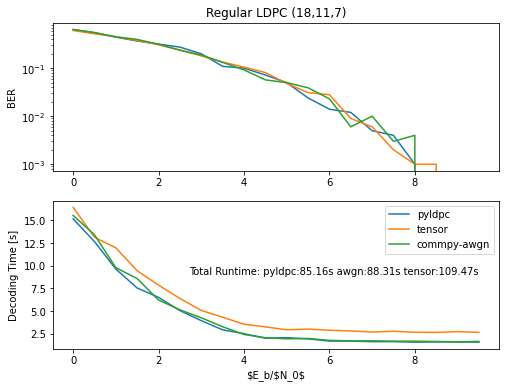

In [10]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [11]:
class GetOutOfLoop( Exception ):
    pass

In [12]:
# Define Model 
from keras.layers.normalization import BatchNormalization

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
#batch_size_x = tf.placeholder(tf.int32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2**input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length, 2**input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  #layer_1 = BatchNormalization ()(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)

input_message_length= 11


In [13]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 2048)
(1, 10000)


In [14]:
batch_size = 500

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 10
outer_ephocs = 1
display_step = 2
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.1
          elif(i < 200):
            lr = 0.01
          else:
            lr = 0.001 
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.05 and snr >= 9): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

batch_size: 500 num_of_batcches: 20.0
max iteration : 400.0 num_of_batches: 20.0
Training for SNR= 0.0  sigma= 1.0 iteratin: 0
Step 2: Minibatch Loss: 124.893570
Step 4: Minibatch Loss: 142.604858
Step 6: Minibatch Loss: 140.239594
Step 8: Minibatch Loss: 142.212418
Step 10: Minibatch Loss: 133.678253
Step 12: Minibatch Loss: 142.292542
Step 14: Minibatch Loss: 129.852844
Step 16: Minibatch Loss: 135.299667
Step 18: Minibatch Loss: 132.050247
Step 20: Minibatch Loss: 135.209427
Step 22: Minibatch Loss: 134.837494
Step 24: Minibatch Loss: 131.575348
Step 26: Minibatch Loss: 137.690811
Step 28: Minibatch Loss: 135.741333
Step 30: Minibatch Loss: 128.179626
Step 32: Minibatch Loss: 125.793549
Step 34: Minibatch Loss: 132.131058
Step 36: Minibatch Loss: 129.494812
Step 38: Minibatch Loss: 132.919769
Step 40: Minibatch Loss: 122.330673
Step 42: Minibatch Loss: 111.941078
Step 44: Minibatch Loss: 117.419792
Step 46: Minibatch Loss: 130.629593
Step 48: Minibatch Loss: 118.214180
Step 50: Mini

In [20]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.33s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.96s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.56s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 6.51s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.35s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.95s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.56s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 6.53s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.62s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.25s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.88s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.46s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 6.22s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.67s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.30s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

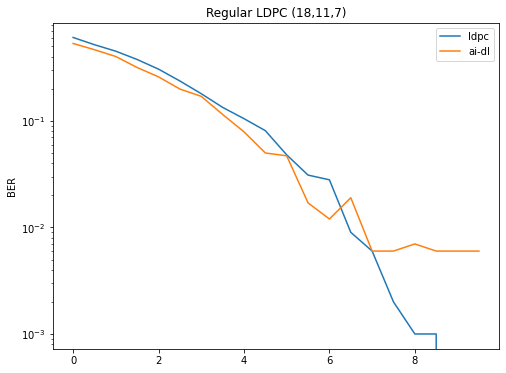

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [22]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 2048)
(1, 1000)


In [23]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.69s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.36s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 2.01s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.68s
SNR: 0.000:
 -> BER: 0.55
 -> Total Time: 6.74s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.68s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.95s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.60s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 6.56s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.59s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.23s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.87s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.51s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 6.20s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.66s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.33s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

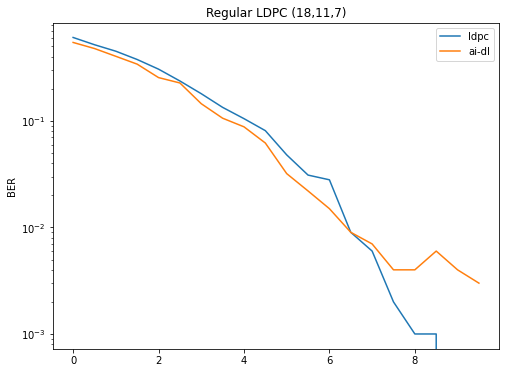

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()